In [44]:
import sys
import os

sys.path.append(os.getenv("CODE_PATH"))
sys.path.append(os.getenv("FIN_DATABASE_PATH"))

import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import ta
from log_config import setup_logging
from Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from Pre_Processing.pre_processing import PreProcessing
from Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from arch import arch_model

In [45]:
#Defining the tickers
tickers = ['AAPL', 'MSFT', 'SPY']

In [46]:
#Using the pipeline script to retrieve data for the above tickers from the SQL database.

pipe = Pipeline(tickers)
minute_data = pipe.pipeline(timespan='minute',start_date='2018-01-01',end_date='2019-01-01')
hourly_data = pipe.pipeline(timespan='hour',start_date='2018-01-01',end_date='2019-01-01')
daily_data = pipe.pipeline(timespan='daily',start_date='2018-01-01',end_date='2019-01-01')


#### Applying the Approach from Young Li's Paper: 
**"A Practical Model for Prediction of Intraday Volatility"**
And testing with GARCH models instead of EWMA



#### Below we will create the Intraday Vol class.This class will contain multiple functions that will be used to predict the intraday volatility of the stock data according to the model described in Young Li's paper

In [47]:
class IntradayVol:
    def __init__(self,tickers, hf_data, lf_data, daily_data, timespan,  decay_factor = 0.94, ret_col='log_ret'):
        """args:
        hf_data: higher frequency dataframe
        lf_data: lower frequency dataframe
        daily_data: daily dataframe
        self.ret_col = ret_var # name of the column in the DataFrame that contains the returns
        
        timespan: timespan of the lower frequency data to aggregate : '15M', '1H', '1D', '1W....'"""
        self.tickers = tickers
        self.hf_data = hf_data
        self.lf_data = lf_data
        self.daily_data = daily_data
        self.timespan = timespan
        self.decay_factor = decay_factor
        self._ewma_vol_cache = {}
        self.ret_col = ret_col

    
    def ewma_vol(self):
        """Calculate daily vol using EWMA model with caching and modify the DataFrame in place."""
        if self._ewma_vol_cache: 
            return self._ewma_vol_cache
        
        vol_results = {}
        for ticker in self.tickers:
            df = self.daily_data [ticker] 

            # Calculate squared log returns
            df['squared_log_ret'] = df[self.ret_col] ** 2
            df['squared_log_ret'].bfill(inplace=True)

            # Initialize the new column directly
            df['daily_vol_squared'] = np.nan
            df.loc[df.index[0], 'daily_vol_squared'] = df['squared_log_ret'].iloc[0]

            # Calculate the EWMA of the squared log returns
            for i in range(1, len(df)):
                df.loc[df.index[i], 'daily_vol_squared'] = (
                    self.decay_factor * df['daily_vol_squared'].iloc[i-1] +
                    (1 - self.decay_factor) * df['squared_log_ret'].iloc[i-1]
                )

            # Calculate the ewma_vol and add it directly to the DataFrame
            df['ewma_vol'] = np.sqrt(df['daily_vol_squared'])*np.sqrt(252)

            # Store the result in the cache
            vol_results[ticker] = df['ewma_vol']
        
        self._ewma_vol_cache = vol_results  # Cache the result
        return vol_results

    
    
    def garch_vol(self, model_type='GARCH'):
        """Calculate daily vol using GARCH(1,1) model and modify the DataFrame in place."""
        vol_results = {}
        for ticker in self.tickers:
            df = self.daily_data[ticker]  
            df.dropna(subset=[self.ret_col], inplace=True)  

            # Fitting GARCH model
            model = arch_model(df[self.ret_col] * 100, vol=model_type, p=1, q=1)
            garch_results = model.fit(disp="off")

            df['garch_vol'] = garch_results.conditional_volatility / 100

            vol_results[ticker] = df['garch_vol'] * np.sqrt(252)

        return vol_results



    def calculate_diurnal_profile(self):
        """Calculate diurnal profile. Basically the average of the Garman-Klass vol for each time of the day. 
        It is calculated using the aggregated data of the higher frequency data"""
        diurnal_results = {}
        for ticker in self.tickers:
            #removing the first datapoint of the day, as it is not a full interval
            df = self.hf_data[ticker]  # Work with the DataFrame for the current ticker
            df = df[df.index.time != pd.Timestamp("09:30:00").time()]


            aggregated_df = df.groupby(df.index.ceil(self.timespan)).aggregate({'open': 'first', 
                                                                'high': 'max', 
                                                                'low': 'min', 
                                                                'close': 'last'})
            
            
            garma_klass_vol = np.sqrt(0.5*(np.log(aggregated_df['high']) - np.log(aggregated_df['low']))**2 - (2 * np.log(2) -1) * (np.log(aggregated_df['close']) - np.log(aggregated_df['open']))**2)
            q5 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.05)
            q25 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.25)
            q50 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.5)
            q75 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.75)
            q95 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.95)
            
            diurnal_profile = (q25 + q50 + q75) / 3
            diurnal_profile = diurnal_profile / diurnal_profile.mean()
            diurnal_results[ticker] = (diurnal_profile, q5, q25, q50, q75, q95)

        return diurnal_results

    # def calculate_dynamic_avg_intraday_vol(self):
    #     self.lf['cum_mean_gk_vol'] = df['gk_vol'].expanding().mean()

    #     # Divide by the daily volatility (GARCH or EWMA)
    #     df['dynamic_avg_intraday_vol'] = df['cum_mean_gk_vol'] / df['garch_vol']

    #     return df
    # apple_hour['date_day'] = apple_hour['date'].dt.date  # Add a date column
    # apple_hour = apple_hour.groupby('date_day').apply(calculate_dynamic_avg_intraday_vol).reset_index(drop=True)

    
    def predict_vol(self):
        """ Predict vol for the next time interval"""
        
        
        daily_vol = self.ewma_vol().shift(1)
        diurnal_profile = self.calculate_diurnal_profile()
        
        # time-scaling factor (rho_t)
        time_scaling_factor = 1  

        self.lf_data['vol_forecasts'] = np.nan
        for i in range(len(self.lf_data)):
            current_time = self.lf_data.index[i].time()
            current_date = self.lf_data.index[i].date()
            
            daily_vol_value = daily_vol.loc[pd.Timestamp(current_date)]
            if current_time in diurnal_profile.index:
                self.lf_data.loc[self.lf_data.index[i], 'vol_forecasts'] = (
                    daily_vol_value * time_scaling_factor * (diurnal_profile[current_time] / avg_diurnal_profile)
                )
            else:
                self.lf_data.loc[self.lf_data.index[i], 'vol_forecasts'] = np.nan
        return self.lf_data


In [ ]:
def plot_diurnal_profile(diurnal_results, combined=False):
    """Plot the diurnal profile with specified intervals on the x-axis."""
    
    if combined:
        for ticker in diurnal_results.keys():
            diurnal_profile, q5, q25, q50, q75, q95 = diurnal_results[ticker]
            times = sorted(diurnal_profile.index.unique())
            
            times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]

            plt.figure(figsize=(12, 6))
            
            plt.plot(times_as_datetime, q50, label="Median (50th percentile)", color='blue')
            

            plt.fill_between(times_as_datetime, q5, q95, color='red', alpha=0.3, label="5th to 95th percentile")
            plt.fill_between(times_as_datetime, q25, q75, color='green', alpha=0.3, label="25th to 75th percentile")
            
            plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
            
            plt.title(f"Diurnal Profile of Garman-Klass Volatility for {ticker}")
            plt.xlabel("Time of Day")
            plt.ylabel("Normalized Volatility")
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
    
    else:
    
        plt.figure(figsize=(12, 6))
        for ticker in diurnal_results.keys():
            diurnal_profile, _, _, _, _, _ = diurnal_results[ticker]
            times = sorted(diurnal_profile.index.unique())
            times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]
            plt.plot(times_as_datetime, diurnal_profile, label=ticker)
        
        plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
        plt.title("Combined Diurnal Profile of Garman-Klass Volatility")
        plt.xlabel("Time of Day")
        plt.ylabel("Normalized Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    
def plot_daily_vol(data, vol_type='garch_vol', combined = True):
    """Plot the estimated daily volatility of the stock.
    Here we use the absolute value of the log returns as the observable vol measure.
    args:
        data: dictionary of dataframes where the key is the ticker and the value is the df
        vol_type: either ewma_vol or garch_vol, according to the model you want to use"""
    
    if combined:
        plt.figure(figsize=(12, 6))
        for ticker in data.keys():
            plt.plot(data[ticker].index, data[ticker][vol_type], label=f"{ticker} {vol_type}")
        
        plt.title("Daily Volatility of Stocks")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else: 
        for ticker in data.keys():
            plt.figure(figsize=(12, 6))
            plt.plot(data[ticker].index, data[ticker][vol_type], label=f"{ticker} {vol_type}")
            plt.plot(data[ticker].index, np.abs(data[ticker]['log_ret']*np.sqrt(252)), label=f"{ticker} Abs Log Returns")
        
            plt.title(f"Daily Volatility of {ticker} ")
            plt.xlabel("Date")
            plt.ylabel("Volatility")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    


In [48]:
intraday_vol = IntradayVol(tickers = tickers, hf_data=minute_data, lf_data=hourly_data, daily_data=daily_data, timespan='30T',ret_col= 'return')

In [49]:
intraday_vol.garch_vol()
intraday_vol.ewma_vol()

{'AAPL': date
 2018-01-03    0.002765
 2018-01-04    0.002765
 2018-01-05    0.018259
 2018-01-08    0.047680
 2018-01-09    0.048431
                 ...   
 2018-12-24    0.400581
 2018-12-26    0.401197
 2018-12-27    0.475694
 2018-12-28    0.461892
 2018-12-31    0.447826
 Name: ewma_vol, Length: 250, dtype: float64,
 'MSFT': date
 2018-01-03    0.073878
 2018-01-04    0.073878
 2018-01-05    0.079383
 2018-01-08    0.090817
 2018-01-09    0.088140
                 ...   
 2018-12-24    0.350848
 2018-12-26    0.376895
 2018-12-27    0.451752
 2018-12-28    0.438646
 2018-12-31    0.426365
 Name: ewma_vol, Length: 250, dtype: float64,
 'SPY': date
 2018-01-03    0.100408
 2018-01-04    0.100408
 2018-01-05    0.098719
 2018-01-08    0.099157
 2018-01-09    0.096399
                 ...   
 2018-12-24    0.233087
 2018-12-26    0.248246
 2018-12-27    0.310687
 2018-12-28    0.302698
 2018-12-31    0.293519
 Name: ewma_vol, Length: 250, dtype: float64}

In [50]:
diurnal_results = intraday_vol.calculate_diurnal_profile()


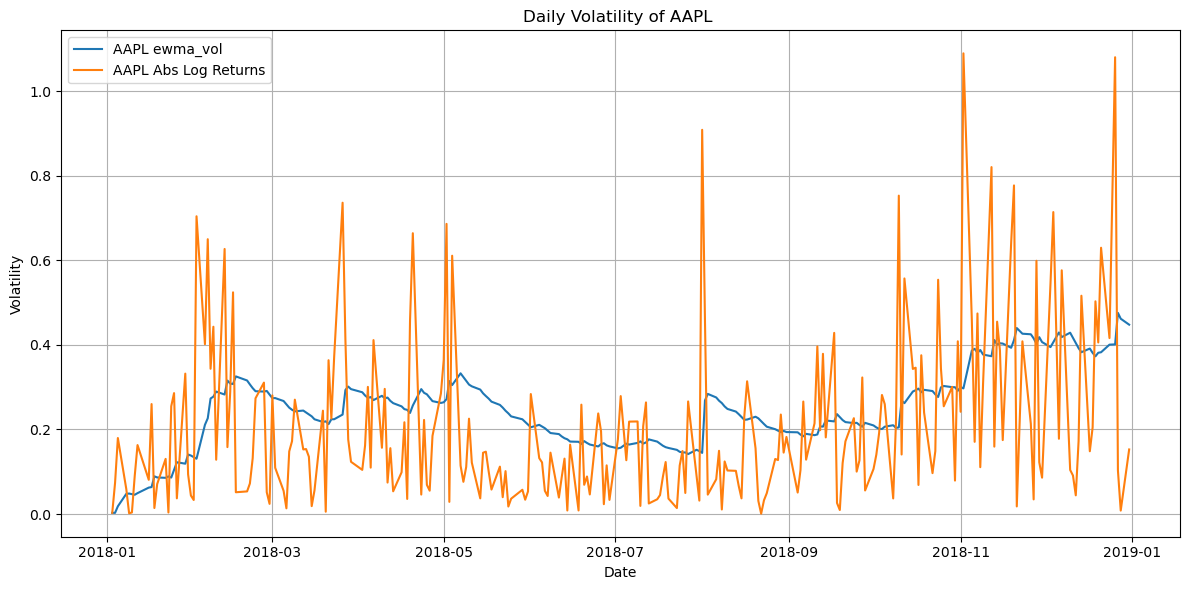

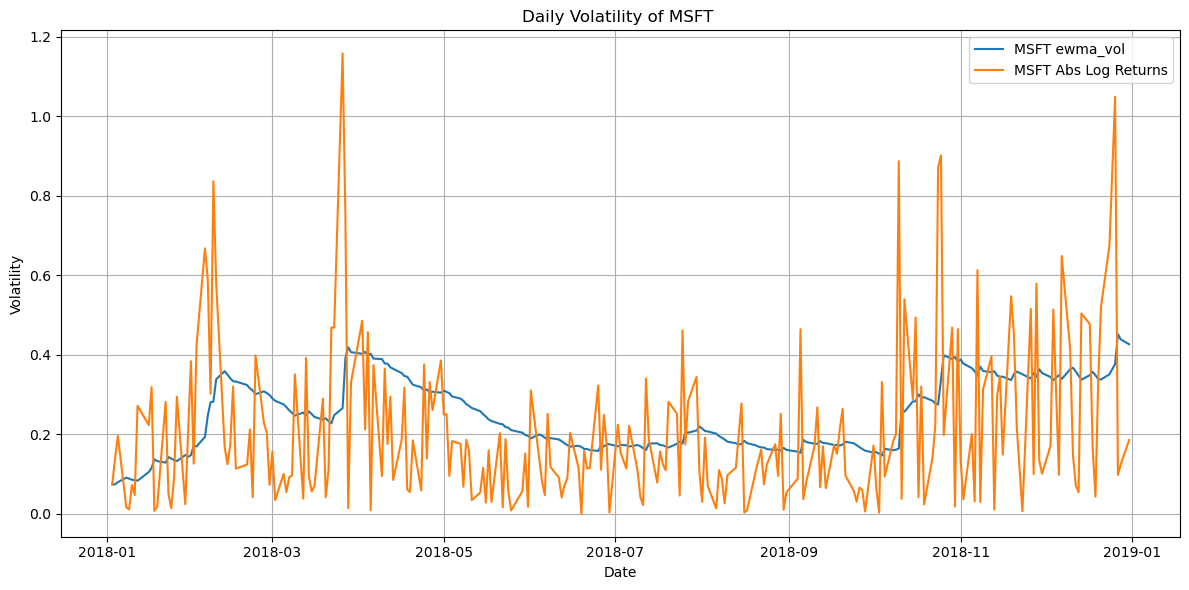

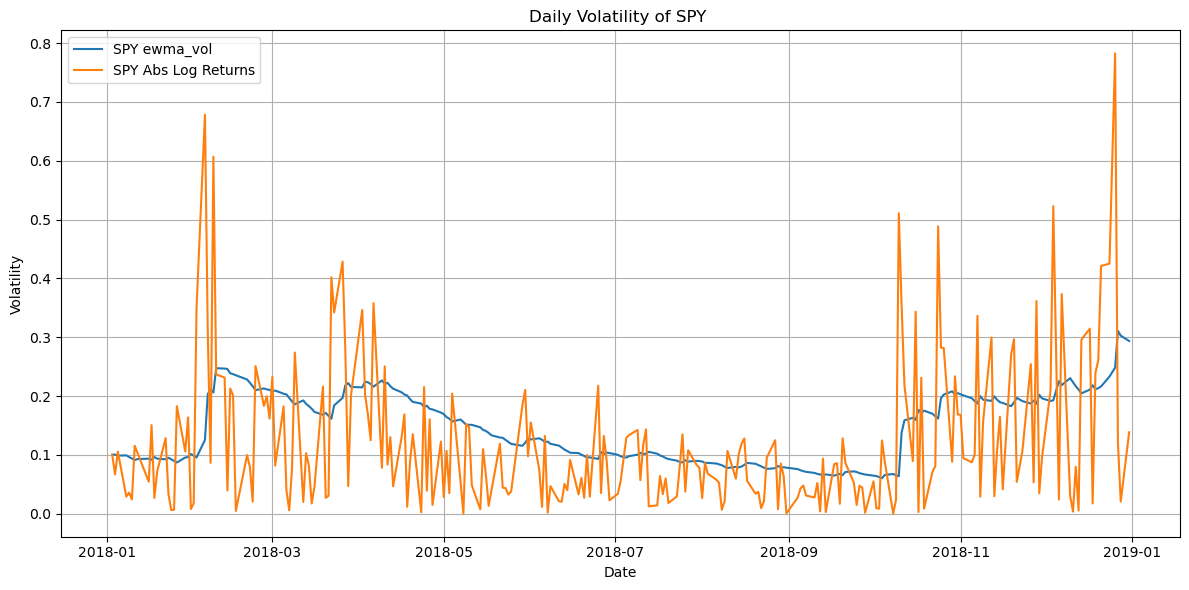

In [51]:
plot_daily_vol(daily_data, combined=False, vol_type='ewma_vol')

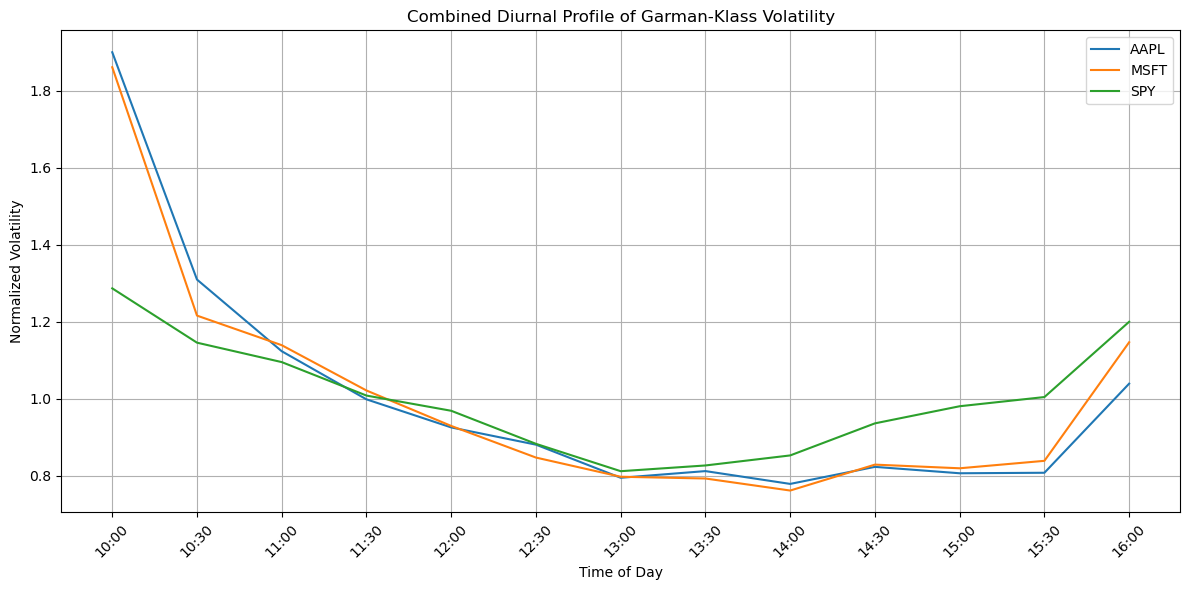

In [52]:
plot_diurnal_profile(diurnal_results)

In [53]:
diurnal_c, q5, q25, q50, q75, q95 = diurnal_results['AAPL']

In [54]:
apple_hour = hourly_data['AAPL']
apple_hour['garch_vol'] = np.nan
apple_hour['ewma_vol'] = np.nan
apple_hour['diurnal_component'] = np.nan
apple_hour['gk_vol'] = np.sqrt(0.5*(np.log(apple_hour['high']) - np.log(apple_hour['low']))**2 - (2 * np.log(2) -1) * (np.log(apple_hour['close']) - np.log(apple_hour['open']))**2)

# Iterate over the hourly data to fill these columns
for i in range(len(apple_hour)):
    # Get the current date and time
    current_time = apple_hour.index[i].time()
    current_date = apple_hour.index[i].date()  # Extract just the date portion
    
    # Convert current_date to a Timestamp (for matching with daily_data index)
    current_date_timestamp = pd.Timestamp(current_date)
    
    # 2. Assign GARCH and EWMA for the current day (repeat for each hour)
    if current_date_timestamp in daily_data['AAPL'].index:
        apple_hour.loc[apple_hour.index[i], 'garch_vol'] = daily_data['AAPL'].loc[current_date_timestamp, 'garch_vol']
        apple_hour.loc[apple_hour.index[i], 'ewma_vol'] = daily_data['AAPL'].loc[current_date_timestamp, 'ewma_vol']
    
    # 3. Assign diurnal component for the current time interval
    if current_time in diurnal_c.index:  # Assume diurnal_c is available
        apple_hour.loc[apple_hour.index[i], 'diurnal_component'] = diurnal_c[current_time]



                         id                date      timestamp ticker  \
date                                                                    
2018-01-02 10:00:00  350826 2018-01-02 10:00:00  1514905200000   AAPL   
2018-01-02 11:00:00  350827 2018-01-02 11:00:00  1514908800000   AAPL   
2018-01-02 12:00:00  350828 2018-01-02 12:00:00  1514912400000   AAPL   
2018-01-02 13:00:00  350829 2018-01-02 13:00:00  1514916000000   AAPL   
2018-01-02 14:00:00  350830 2018-01-02 14:00:00  1514919600000   AAPL   

                        open     high      low    close      volume     vwap  \
date                                                                           
2018-01-02 10:00:00  42.7425  42.9000  42.7150  42.8763  17568136.0  42.8237   
2018-01-02 11:00:00  42.8750  42.8825  42.7750  42.8025  10635548.0  42.8239   
2018-01-02 12:00:00  42.8013  42.8750  42.7975  42.8200   7039704.0  42.8375   
2018-01-02 13:00:00  42.8225  42.9250  42.8210  42.9222   7718704.0  42.8879   
2018-01-

In [58]:
apple_hour

,date,ticker,open,high,low,close,log_ret,return,garch_vol,ewma_vol,diurnal_component,gk_vol
date,,,,,,,,,,,,
2018-01-03 10:00:00,2018-01-03 10:00:00,AAPL,43.4725,43.6375,43.4400,43.5375,0.011260,0.011324,0.01446,0.002765,1.899869,0.003070
2018-01-03 11:00:00,2018-01-03 11:00:00,AAPL,43.5400,43.5725,43.3750,43.4150,-0.002818,-0.002814,0.01446,0.002765,1.123426,0.002670
2018-01-03 12:00:00,2018-01-03 12:00:00,AAPL,43.4175,43.4325,43.3050,43.3300,-0.001960,-0.001958,0.01446,0.002765,0.925549,0.001658
2018-01-03 13:00:00,2018-01-03 13:00:00,AAPL,43.3325,43.3725,43.2325,43.2430,-0.002010,-0.002008,0.01446,0.002765,0.794776,0.001891
2018-01-03 14:00:00,2018-01-03 14:00:00,AAPL,43.2450,43.2713,43.0825,43.0975,-0.003370,-0.003365,0.01446,0.002765,0.778855,0.002247
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 12:00:00,2018-12-31 12:00:00,AAPL,39.4975,39.7350,39.4350,39.5925,0.002592,0.002596,0.03023,0.447826,0.925549,0.005147
2018-12-31 13:00:00,2018-12-31 13:00:00,AAPL,39.5950,39.6200,39.3589,39.3925,-0.005064,-0.005051,0.03023,0.447826,0.794776,0.003421
2018-12-31 14:00:00,2018-12-31 14:00:00,AAPL,39.3950,39.4550,39.2125,39.3425,-0.001270,-0.001269,0.03023,0.447826,0.778855,0.004280


In [57]:
columns_to_drop = ['ROC', 'Stoch', 'ADX', 'ADX_pos', 'ADX_neg', 'rolling_H-L_25',
       'lower_band', 'ATR', 'IBS', 'OBV', 'sma_5', 'ema_5', 'sma_10', 'ema_10',
       'sma_30', 'ema_30', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'sma_200',
       'ema_200', 'sma_300', 'ema_300','volume', 'vwap', 'transactions', 'RSI_14', 'RSI_2', 'MACD',
       'id', 'day', 'timestamp', 'month', 'day_of_week'
       ]
apple_hour.drop(columns=columns_to_drop, inplace=True)
apple_hour.dropna(subset=['garch_vol'], inplace=True)

In [61]:
# Apply the function to each group (each day)
apple_hour = apple_hour.groupby(apple_hour['date'].dt.date).apply(calculate_dynamic_avg_intraday_vol)

In [67]:
apple_hour

date ticker     open     high  \
date       date                                                               
2018-01-03 2018-01-03 10:00:00 2018-01-03 10:00:00   AAPL  43.4725  43.6375   
           2018-01-03 11:00:00 2018-01-03 11:00:00   AAPL  43.5400  43.5725   
           2018-01-03 12:00:00 2018-01-03 12:00:00   AAPL  43.4175  43.4325   
           2018-01-03 13:00:00 2018-01-03 13:00:00   AAPL  43.3325  43.3725   
           2018-01-03 14:00:00 2018-01-03 14:00:00   AAPL  43.2450  43.2713   
...                                            ...    ...      ...      ...   
2018-12-31 2018-12-31 12:00:00 2018-12-31 12:00:00   AAPL  39.4975  39.7350   
           2018-12-31 13:00:00 2018-12-31 13:00:00   AAPL  39.5950  39.6200   
           2018-12-31 14:00:00 2018-12-31 14:00:00   AAPL  39.3950  39.4550   
           2018-12-31 15:00:00 2018-12-31 15:00:00   AAPL  39.3400  39.4875   
           2018-12-31 16:00:00 2018-12-31 16:00:00   AAPL  39.4350  39.4625   

                                    low    close   log_ret    return  \
date       date                                                        
2018-01-03 2018-01-03 10:00:00  43.4400  43.5375  0.011260  0.011324   
           2018-01-03 11:00:00  43.3750  43.4150 -0.002818 -0.002814   
           2018-01-03 12:00:00  43.3050  43.3300 -0.001960 -0.001958   
           2018-01-03 13:00:00  43.2325  43.2430 -0.002010 -0.002008   
           2018-01-03 14:00:00  43.0825  43.0975 -0.003370 -0.003365   
...                                 ...      ...       ...       ...   
2018-12-31 2018-12-31 12:00:00  39.4350  39.5925  0.002592  0.002596   
           2018-12-31 13:00:00  39.3589  39.3925 -0.005064 -0.005051   
           2018-12-31 14:00:00  39.2125  39.3425 -0.001270 -0.001269   
           2018-12-31 15:00:00  39.1200  39.4850  0.003615  0.003622   
           2018-12-31 16:00:00  39.3500  39.4425 -0.001077 -0.001076   

                                garch_vol  ewma_vol  diurnal_component  \
date       date                                                          
2018-01-03 2018-01-03 10:00:00    0.01446  0.002765           1.899869   
           2018-01-03 11:00:00    0.01446  0.002765           1.123426   
           2018-01-03 12:00:00    0.01446  0.002765           0.925549   
           2018-01-03 13:00:00    0.01446  0.002765           0.794776   
           2018-01-03 14:00:00    0.01446  0.002765           0.778855   
...                                   ...       ...                ...   
2018-12-31 2018-12-31 12:00:00    0.03023  0.447826           0.925549   
           2018-12-31 13:00:00    0.03023  0.447826           0.794776   
           2018-12-31 14:00:00    0.03023  0.447826           0.778855   
           2018-12-31 15:00:00    0.03023  0.447826           0.806497   
           2018-12-31 16:00:00    0.03023  0.447826           1.039224   

                                  gk_vol  cum_mean_gk_vol  \
date       date                                             
2018-01-03 2018-01-03 10:00:00  0.003070         0.003070   
           2018-01-03 11:00:00  0.002670         0.002870   
           2018-01-03 12:00:00  0.001658         0.002466   
           2018-01-03 13:00:00  0.001891         0.002322   
           2018-01-03 14:00:00  0.002247         0.002307   
...                                  ...              ...   
2018-12-31 2018-12-31 12:00:00  0.005147         0.005513   
           2018-12-31 13:00:00  0.003421         0.004990   
           2018-12-31 14:00:00  0.004280         0.004848   
           2018-12-31 15:00:00  0.006204         0.005074   
           2018-12-31 16:00:00  0.002015         0.004637   

                                dynamic_avg_intraday_vol  predicted_vol  
date       date                                                          
2018-01-03 2018-01-03 10:00:00                  0.212327       0.003449  
           2018-01-03 11:00:00                  0.198471       0.002656  
           2018-01-03 12:00:

In [68]:
apple_hour['predicted_vol'] = apple_hour['garch_vol'] *apple_hour['dynamic_avg_intraday_vol'] *  apple_hour['diurnal_component']

In [71]:
apple_hour['predicted_vol'] = apple_hour['predicted_vol'].shift(1)

In [69]:
apple_hour

date ticker     open     high  \
date       date                                                               
2018-01-03 2018-01-03 10:00:00 2018-01-03 10:00:00   AAPL  43.4725  43.6375   
           2018-01-03 11:00:00 2018-01-03 11:00:00   AAPL  43.5400  43.5725   
           2018-01-03 12:00:00 2018-01-03 12:00:00   AAPL  43.4175  43.4325   
           2018-01-03 13:00:00 2018-01-03 13:00:00   AAPL  43.3325  43.3725   
           2018-01-03 14:00:00 2018-01-03 14:00:00   AAPL  43.2450  43.2713   
...                                            ...    ...      ...      ...   
2018-12-31 2018-12-31 12:00:00 2018-12-31 12:00:00   AAPL  39.4975  39.7350   
           2018-12-31 13:00:00 2018-12-31 13:00:00   AAPL  39.5950  39.6200   
           2018-12-31 14:00:00 2018-12-31 14:00:00   AAPL  39.3950  39.4550   
           2018-12-31 15:00:00 2018-12-31 15:00:00   AAPL  39.3400  39.4875   
           2018-12-31 16:00:00 2018-12-31 16:00:00   AAPL  39.4350  39.4625   

                                    low    close   log_ret    return  \
date       date                                                        
2018-01-03 2018-01-03 10:00:00  43.4400  43.5375  0.011260  0.011324   
           2018-01-03 11:00:00  43.3750  43.4150 -0.002818 -0.002814   
           2018-01-03 12:00:00  43.3050  43.3300 -0.001960 -0.001958   
           2018-01-03 13:00:00  43.2325  43.2430 -0.002010 -0.002008   
           2018-01-03 14:00:00  43.0825  43.0975 -0.003370 -0.003365   
...                                 ...      ...       ...       ...   
2018-12-31 2018-12-31 12:00:00  39.4350  39.5925  0.002592  0.002596   
           2018-12-31 13:00:00  39.3589  39.3925 -0.005064 -0.005051   
           2018-12-31 14:00:00  39.2125  39.3425 -0.001270 -0.001269   
           2018-12-31 15:00:00  39.1200  39.4850  0.003615  0.003622   
           2018-12-31 16:00:00  39.3500  39.4425 -0.001077 -0.001076   

                                garch_vol  ewma_vol  diurnal_component  \
date       date                                                          
2018-01-03 2018-01-03 10:00:00    0.01446  0.002765           1.899869   
           2018-01-03 11:00:00    0.01446  0.002765           1.123426   
           2018-01-03 12:00:00    0.01446  0.002765           0.925549   
           2018-01-03 13:00:00    0.01446  0.002765           0.794776   
           2018-01-03 14:00:00    0.01446  0.002765           0.778855   
...                                   ...       ...                ...   
2018-12-31 2018-12-31 12:00:00    0.03023  0.447826           0.925549   
           2018-12-31 13:00:00    0.03023  0.447826           0.794776   
           2018-12-31 14:00:00    0.03023  0.447826           0.778855   
           2018-12-31 15:00:00    0.03023  0.447826           0.806497   
           2018-12-31 16:00:00    0.03023  0.447826           1.039224   

                                  gk_vol  cum_mean_gk_vol  \
date       date                                             
2018-01-03 2018-01-03 10:00:00  0.003070         0.003070   
           2018-01-03 11:00:00  0.002670         0.002870   
           2018-01-03 12:00:00  0.001658         0.002466   
           2018-01-03 13:00:00  0.001891         0.002322   
           2018-01-03 14:00:00  0.002247         0.002307   
...                                  ...              ...   
2018-12-31 2018-12-31 12:00:00  0.005147         0.005513   
           2018-12-31 13:00:00  0.003421         0.004990   
           2018-12-31 14:00:00  0.004280         0.004848   
           2018-12-31 15:00:00  0.006204         0.005074   
           2018-12-31 16:00:00  0.002015         0.004637   

                                dynamic_avg_intraday_vol  predicted_vol  
date       date                                                          
2018-01-03 2018-01-03 10:00:00                  0.212327       0.005833  
           2018-01-03 11:00:00                  0.198471       0.003224  
           2018-01-03 12:00:

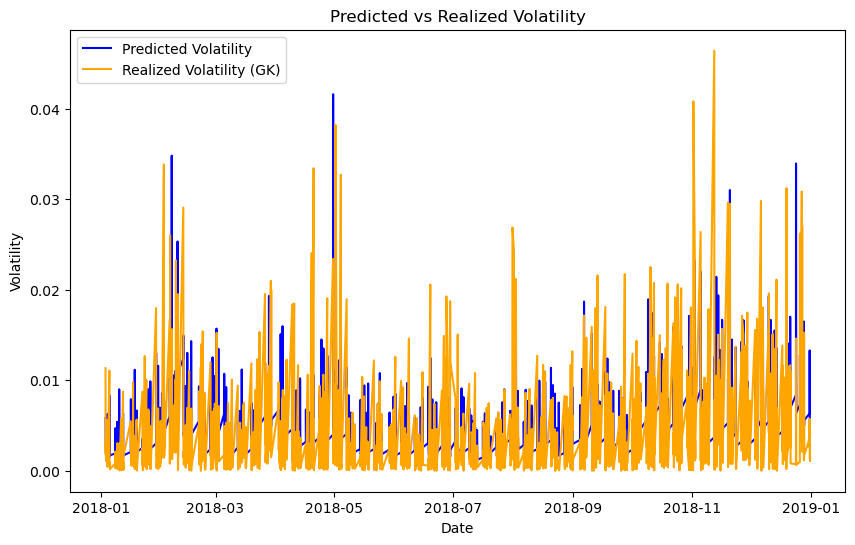

In [76]:
apple_hour['date'] = pd.to_datetime(apple_hour['date'])

# Plot predicted_vol and gk_vol against 'date' using the existing 'date' column
plt.figure(figsize=(10, 6))
plt.plot(apple_hour['date'], apple_hour['predicted_vol'], label='Predicted Volatility', color='blue')
plt.plot(apple_hour['date'], np.abs(apple_hour['return']), label='Realized Volatility (GK)', color='orange')
plt.legend()
plt.title("Predicted vs Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [75]:
rmse(np.abs(apple_hour['return']).iloc[1:-1], apple_hour['predicted_vol'].iloc[1:-1])

0.005673399305106597